## Imports

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("husl")
sns.set_style("darkgrid")

import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, AvgPool2D, Dropout, Flatten, Activation, ReLU, BatchNormalization
from keras.metrics import binary_accuracy, categorical_accuracy
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

## Helpers

In [37]:
def plot_history(train_data):
    labels = ['angry','disgust','fear','happy','sad','surprise','neutral']
    

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,10))
    
    
    main_plot_train_acc_legend = []
    main_plot_test_acc_legend = []
    main_plot_train_loss_legend = []
    main_plot_test_loss_legend = []
    for data in train_data:
        history = data[0].history
        title = data[1]
        
        ax1.plot(history['accuracy'], linestyle=':')
        main_plot_train_acc_legend.append(title+' - acc')
        ax2.plot(history['val_accuracy'])
        main_plot_test_acc_legend.append(title+' - val acc')
        ax3.plot(history['loss'], linestyle=':')
        main_plot_train_loss_legend.append(title+' - loss')
        ax4.plot(history['val_loss'])
        main_plot_test_loss_legend.append(title+' - loss')
        
    ax1.set(title="Overall train accuracy performance", xlabel='epoch', ylabel='accuracy')
    ax1.legend(main_plot_train_acc_legend)
    ax2.set(title="Overall test accuracy performance", xlabel='epoch', ylabel='accuracy')
    ax2.legend(main_plot_test_acc_legend)
    ax3.set(title="Overall train loss performance", xlabel='epoch', ylabel='accuracy')
    ax3.legend(main_plot_train_loss_legend)
    ax4.set(title="Overall test loss performance", xlabel='epoch', ylabel='accuracy')
    ax4.legend(main_plot_test_loss_legend)    
    
    for data in train_data:
        history = data[0].history
        title = data[1]
        true = data[2]
        preds = data[3]
        
        fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16,5))
        fig.suptitle(title, fontsize=18, y=1.05, color='b')
        ax1.plot(history['accuracy'], linestyle=':')
        ax1.plot(history['val_accuracy'])
        ax1.legend(['train', 'val'])
        ax1.set(title=f"train acc : {history['accuracy'][-1]}\nval acc : {history['val_accuracy'][-1]}", 
                  xlabel='epoch', ylabel='accuracy')

        ax2.plot(history['loss'], linestyle=':')
        ax2.plot(history['val_loss'])
        ax2.legend(['train', 'val'])
        ax2.set(title=f"train loss : {history['loss'][-1]}\nval loss : {history['val_loss'][-1]}", 
                  xlabel='epoch', ylabel='loss')
        plt.show()
        print(classification_report(np.argmax(true, axis=1), np.argmax(preds, axis=1), target_names=labels))

## Load dataset

In [4]:
labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
data = pd.read_csv('data/FER2013/fer2013.csv')
X = []
for index, row in data.iterrows():
    image_pixels = np.asarray(list(row['pixels'].split(' ')), dtype=np.float32)
    image_pixels = image_pixels.reshape((48,48))
    X.append(image_pixels)
X = np.array(X)
X = np.expand_dims(X, 3)

y = to_categorical(data['emotion'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mean = np.mean(X)
std = np.std(X)
X_test = (X_test - mean)/std

train_gen = ImageDataGenerator(featurewise_center=True,
                               featurewise_std_normalization=True,
                               horizontal_flip=True)
train_gen.fit(X_train)
train_generator = train_gen.flow(X_train, y_train, batch_size=128)

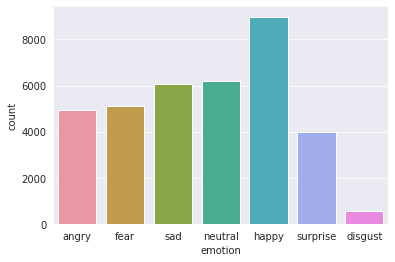

In [5]:
sns.countplot(data['emotion'].apply(lambda x : labels.get(x)))
plt.show()

From the above countplot graphic we can check that: 
- we have way more __*happy*__ samples than the rest of the other ones. 
- __*disgust*__ samples are almost 7 times less if compared to the category with more samples, __*happy*__.
- it is necessary to keep an eye on this imbalance on categories, once it may lead our model to bias towards happy labels and miss a lot of disgust samples.

## Models

####  Lenet

In [10]:
def build_lenet5():
    model = Sequential(name='LeNet-5')
    # Layer C1 (convolution) - 6 feature maps 28x28
    model.add(Conv2D(6, (5,5), strides=(1,1), input_shape=(48,48,1), name='C1', activation='relu'))
    
    # Layer S2 (sub-sampling) - 6 feature maps 14x14
    model.add(AvgPool2D(pool_size=(2,2), name='S2'))
    
    # Layer C3 (convolution) - 16 feature maps 10x10
    model.add(Conv2D(16, (5,5), strides=(1,1), name='C3', activation='relu'))
    
    # Layer S4 (sub-samlping) - 16 feature maps 5x5
    model.add(AvgPool2D(pool_size=(2,2), name='S4'))
    
    # Layer C5 (convolution) - 16 feature maps 10x10 - Flattened layer
    model.add(Conv2D(120, (4,4), strides=(1,1), name='C5', activation='relu'))
    model.add(Flatten(name='C5-Flat'))
    model.add(Dense(120, name='C5-Dense', activation='relu'))
    
    # Layer F6 - Full connection 84
    model.add(Dense(84, name='F6'))
    
    # Output layer
    model.add(Dense(7, activation='softmax', name='Output'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model

#### Custom Model 1

In [9]:
def build_custom1():
    model = Sequential(name='Custom 1')

    model.add(Conv2D(64, (3,3), strides=(1,1), input_shape=(48,48,1), activation='relu'))
    model.add(Conv2D(64, (3,3), strides=(1,1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(Conv2D(128, (3,3), strides=(1,1), activation='relu'))
    model.add(Conv2D(128, (3,3), strides=(1,1), activation='relu'))
    model.add(Conv2D(256, (3,3), strides=(1,1), activation='relu'))
    model.add(Conv2D(128, (3,3), strides=(1,1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(rate=0.25))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(rate=0.25))
    model.add(Dense(7, activation='softmax', name='Output'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model

#### Custom Model 2

In [8]:
def build_custom2():
    model = Sequential(name='Custom 2')
    
    model.add(Conv2D(64, (3,3), strides=(1,1), input_shape=(48,48,1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(rate=0.25))
    
    model.add(Conv2D(512, (3,3), strides=(1,1), input_shape=(48,48,1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(rate=0.25))
    
    model.add(Conv2D(512, (3,3), strides=(1,1), input_shape=(48,48,1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(rate=0.25))
    
    model.add(Conv2D(256, (3,3), strides=(1,1), input_shape=(48,48,1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(rate=0.25))
    
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(rate=0.25))
    model.add(Dense(7, activation='softmax', name='Output'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    
    return model

## Models tests

In [11]:
test_history = []

#### Test 1

- Model Lenet
- no pixel modification
- train/test ration = 0.8

In [12]:
model = build_lenet5()
history = model.fit_generator(train_generator, steps_per_epoch=224, epochs=15, validation_data=(X_test, y_test))
preds = model.predict(X_test)
test_history.append((history, 'Model Lenet - vanilla', y_test, preds))



Epoch 1/15
224/224 [==============================] - 3s 14ms/step - loss: 1.5962 - accuracy: 0.3732 - val_loss: 1.4857 - val_accuracy: 0.4238
Epoch 2/15
224/224 [==============================] - 2s 10ms/step - loss: 1.4156 - accuracy: 0.4537 - val_loss: 1.3821 - val_accuracy: 0.4654
Epoch 3/15
224/224 [==============================] - 2s 10ms/step - loss: 1.3169 - accuracy: 0.4976 - val_loss: 1.3033 - val_accuracy: 0.4975
Epoch 4/15
224/224 [==============================] - 2s 10ms/step - loss: 1.2426 - accuracy: 0.5231 - val_loss: 1.2542 - val_accuracy: 0.5240
Epoch 5/15
224/224 [==============================] - 2s 10ms/step - loss: 1.1780 - accuracy: 0.5541 - val_loss: 1.2441 - val_accuracy: 0.5300
Epoch 6/15
224/224 [==============================] - 2s 10ms/step - loss: 1.1196 - accuracy: 0.5767 - val_loss: 1.2195 - val_accuracy: 0.5309
Epoch 7/15
224/224 [==============================] - 2s 10ms/step - loss: 1.0758 - accuracy: 0.5959 - val_loss: 1.1888 - val_accuracy: 0.54

#### Test 2

- Model Custom 1
- pixel normalization : mean + std
- train/test ration = 0.8

In [13]:
model = build_custom1()
history = model.fit_generator(train_generator, steps_per_epoch=224, epochs=30, validation_data=(X_test, y_test))
preds = model.predict(X_test)
test_history.append((history, 'Model Custom 1 - 30 epochs', y_test, preds))


Epoch 1/30
224/224 [==============================] - 21s 95ms/step - loss: 1.6829 - accuracy: 0.3265 - val_loss: 1.4868 - val_accuracy: 0.4324
Epoch 2/30
224/224 [==============================] - 20s 90ms/step - loss: 1.3926 - accuracy: 0.4635 - val_loss: 1.3079 - val_accuracy: 0.5020
Epoch 3/30
224/224 [==============================] - 20s 90ms/step - loss: 1.2587 - accuracy: 0.5183 - val_loss: 1.2047 - val_accuracy: 0.5432
Epoch 4/30
224/224 [==============================] - 20s 90ms/step - loss: 1.1867 - accuracy: 0.5465 - val_loss: 1.1771 - val_accuracy: 0.5543
Epoch 5/30
224/224 [==============================] - 20s 90ms/step - loss: 1.1356 - accuracy: 0.5662 - val_loss: 1.1451 - val_accuracy: 0.5676
Epoch 6/30
224/224 [==============================] - 20s 90ms/step - loss: 1.0914 - accuracy: 0.5850 - val_loss: 1.1167 - val_accuracy: 0.5752
Epoch 7/30
224/224 [==============================] - 20s 90ms/step - loss: 1.0547 - accuracy: 0.6005 - val_loss: 1.0857 - val_accuracy

#### Test 3

- Model Custom 2
- pixel normalization : mean + std
- train/test ration = 0.8

In [14]:
model = build_custom2()
history = model.fit_generator(train_generator, steps_per_epoch=224, epochs=30, validation_data=(X_test, y_test))
preds = model.predict(X_test)
test_history.append((history, 'Model Custom 2 - 30 epochs', y_test, preds))

Epoch 1/30
224/224 [==============================] - 22s 99ms/step - loss: 1.6998 - accuracy: 0.3030 - val_loss: 1.4895 - val_accuracy: 0.4181
Epoch 2/30
224/224 [==============================] - 21s 93ms/step - loss: 1.4020 - accuracy: 0.4613 - val_loss: 1.2649 - val_accuracy: 0.5196
Epoch 3/30
224/224 [==============================] - 21s 93ms/step - loss: 1.2793 - accuracy: 0.5108 - val_loss: 1.1951 - val_accuracy: 0.5421
Epoch 4/30
224/224 [==============================] - 21s 93ms/step - loss: 1.2100 - accuracy: 0.5391 - val_loss: 1.1763 - val_accuracy: 0.5511
Epoch 5/30
224/224 [==============================] - 21s 93ms/step - loss: 1.1714 - accuracy: 0.5534 - val_loss: 1.1360 - val_accuracy: 0.5701
Epoch 6/30
224/224 [==============================] - 21s 93ms/step - loss: 1.1411 - accuracy: 0.5630 - val_loss: 1.0937 - val_accuracy: 0.5890
Epoch 7/30
224/224 [==============================] - 21s 93ms/step - loss: 1.1150 - accuracy: 0.5772 - val_loss: 1.0827 - val_accuracy:

## Results visualisation

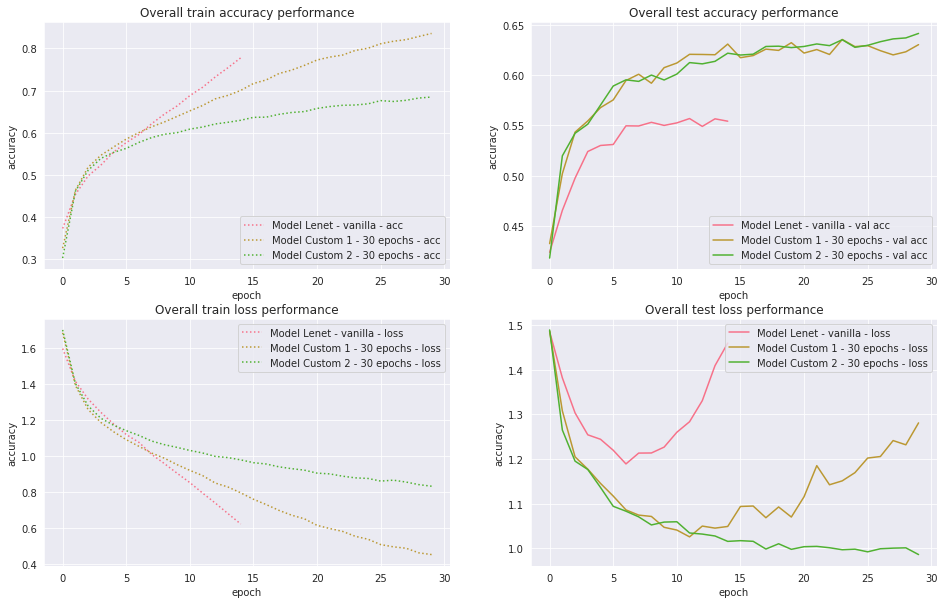

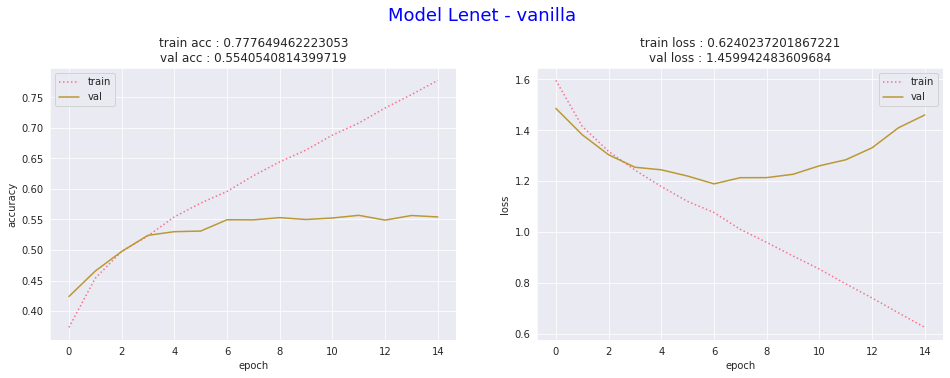

              precision    recall  f1-score   support

       angry       0.48      0.42      0.45       985
     disgust       0.62      0.47      0.54       102
        fear       0.40      0.41      0.41      1043
       happy       0.75      0.77      0.76      1765
         sad       0.39      0.55      0.46      1210
    surprise       0.72      0.64      0.68       795
     neutral       0.58      0.42      0.49      1278

    accuracy                           0.55      7178
   macro avg       0.56      0.53      0.54      7178
weighted avg       0.57      0.55      0.56      7178



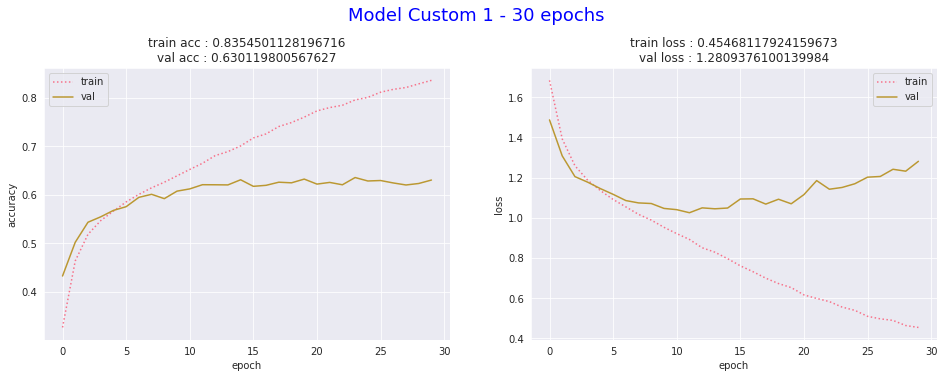

              precision    recall  f1-score   support

       angry       0.55      0.55      0.55       985
     disgust       0.73      0.51      0.60       102
        fear       0.52      0.40      0.45      1043
       happy       0.79      0.84      0.82      1765
         sad       0.52      0.53      0.52      1210
    surprise       0.75      0.75      0.75       795
     neutral       0.57      0.60      0.59      1278

    accuracy                           0.63      7178
   macro avg       0.63      0.60      0.61      7178
weighted avg       0.63      0.63      0.63      7178



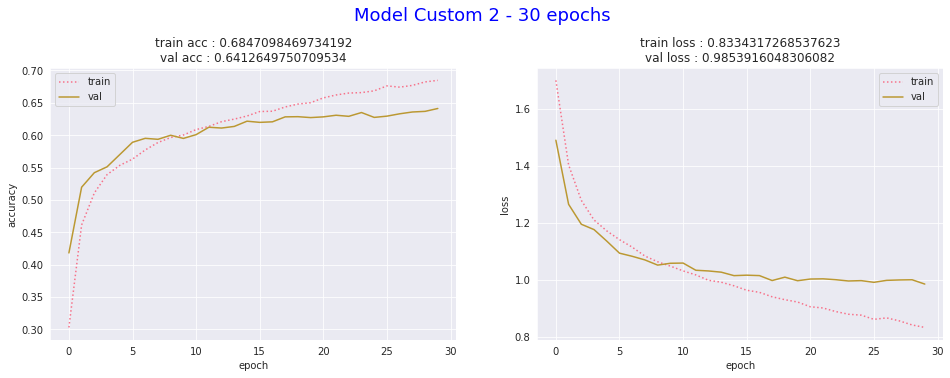

              precision    recall  f1-score   support

       angry       0.59      0.56      0.57       985
     disgust       0.63      0.44      0.52       102
        fear       0.52      0.40      0.45      1043
       happy       0.81      0.87      0.84      1765
         sad       0.50      0.52      0.51      1210
    surprise       0.76      0.76      0.76       795
     neutral       0.58      0.65      0.61      1278

    accuracy                           0.64      7178
   macro avg       0.63      0.60      0.61      7178
weighted avg       0.64      0.64      0.64      7178



In [38]:
plot_history(test_history)